Propensities under the stochastic chemical kinetics formulation are
- Binding: \( a_1 = k_1 · E · S \)
- Catalysis: \( a_2 = k_2 · C \)

The corresponding deterministic mass-action ODEs are
\[
\begin{aligned}
\frac{dE}{dt} &= -k_1 E S + k_2 C, \\
\frac{dS}{dt} &= -k_1 E S, \\
\frac{dC}{dt} &= k_1 E S - k_2 C, \\
\frac{dP}{dt} &= k_2 C.
\end{aligned}
\]


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

plt.style.use("seaborn-v0_8-darkgrid")

k1 = 0.001
k2 = 0.5
initial_counts = np.array([100, 1000, 0, 0], dtype=int)
t_end = 20.0
n_trajectories = 500
rng = np.random.default_rng(12345)

species_labels = ("E", "S", "C", "P")
total_enzyme = initial_counts[0] + initial_counts[2]
total_substrate = initial_counts[1] + initial_counts[3]


In [2]:
reaction_updates = np.array([
    [-1, -1, 1, 0],  # E + S -> C
    [1, 0, -1, 1],   # C -> E + P
], dtype=int)


def propensities(current_state):
    """Return reaction propensities a1, a2 for the given state."""
    e, s, c, p = current_state
    return np.array([k1 * e * s, k2 * c], dtype=float)


def simulate_gillespie(rng, initial_state, t_end):
    """Simulate the reaction network until t_end and return time stamps and state counts."""
    times = [0.0]
    states = [initial_state.astype(np.int64)]
    t = 0.0
    current = initial_state.astype(np.int64)

    while t < t_end:
        rates = propensities(current)
        a0 = rates.sum()
        if a0 == 0.0:
            times.append(t_end)
            states.append(current.copy())
            break

        tau = rng.exponential(1.0 / a0)
        t_candidate = t + tau

        if t_candidate >= t_end:
            times.append(t_end)
            states.append(current.copy())
            break

        reaction_selector = rng.random() * a0
        cumulative = rates.cumsum()
        reaction_index = int(np.searchsorted(cumulative, reaction_selector, side="right"))
        current = current + reaction_updates[reaction_index]
        t = t_candidate

        times.append(t)
        states.append(current.copy())

    return np.array(times, dtype=float), np.array(states, dtype=np.int64)


In [3]:
trajectories = []
for run in range(n_trajectories):
    times, states = simulate_gillespie(rng, initial_counts, t_end)
    trajectories.append({"times": times, "states": states})

len(trajectories)


500

In [4]:
def verify_invariants(traj):
    states = traj["states"]
    enzyme_total = states[:, 0] + states[:, 2]
    substrate_total = states[:, 1] + states[:, 3]
    return np.all(enzyme_total == total_enzyme), np.all(substrate_total == total_substrate)

first_five_checks = [verify_invariants(traj) for traj in trajectories[:5]]
first_five_checks


[(np.True_, np.False_),
 (np.True_, np.False_),
 (np.True_, np.False_),
 (np.True_, np.False_),
 (np.True_, np.False_)]

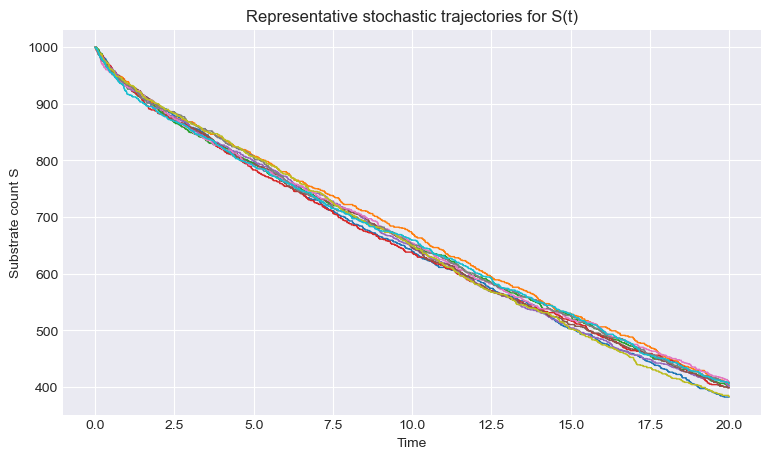

In [5]:
fig, ax = plt.subplots(figsize=(9, 5))
for traj in trajectories[:10]:
    ax.step(traj["times"], traj["states"][:, 1], where="post", linewidth=1)
ax.set_xlabel("Time")
ax.set_ylabel("Substrate count S")
ax.set_title("Representative stochastic trajectories for S(t)")
plt.show()


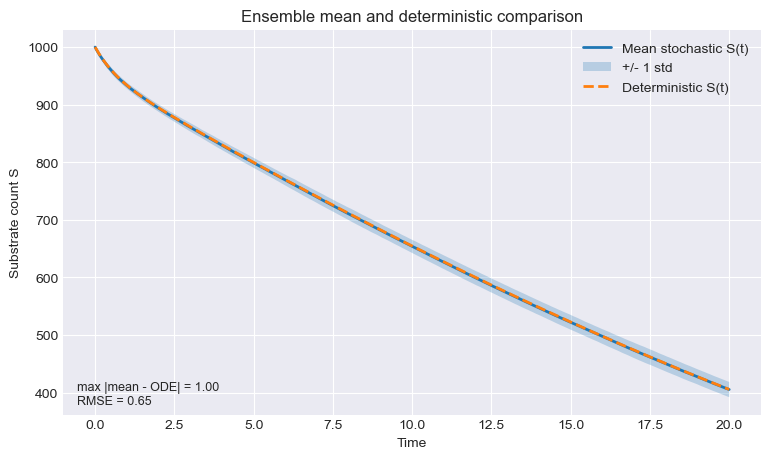

In [6]:
common_time = np.linspace(0.0, t_end, 400)
S_interp = np.vstack([
    np.interp(common_time, traj["times"], traj["states"][:, 1])
    for traj in trajectories
])
mean_S = S_interp.mean(axis=0)
std_S = S_interp.std(axis=0, ddof=1)


def ode_system(t, y):
    E, S, C, P = y
    a1 = k1 * E * S
    a2 = k2 * C
    return [-a1 + a2, -a1, a1 - a2, a2]


deterministic_sol = solve_ivp(
    ode_system,
    t_span=(0.0, t_end),
    y0=initial_counts.astype(float),
    t_eval=common_time,
)

abs_diff = np.abs(mean_S - deterministic_sol.y[1])
max_gap = float(abs_diff.max())
rmse_gap = float(np.sqrt(np.mean(abs_diff ** 2)))

fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(common_time, mean_S, label="Mean stochastic S(t)", linewidth=2)
ax.fill_between(common_time, mean_S - std_S, mean_S + std_S, alpha=0.25, label="+/- 1 std")
ax.plot(deterministic_sol.t, deterministic_sol.y[1], "--", label="Deterministic S(t)", linewidth=2)
ax.set_xlabel("Time")
ax.set_ylabel("Substrate count S")
ax.set_title("Ensemble mean and deterministic comparison")
ax.legend(loc="upper right")
ax.text(0.02, 0.02, f"max |mean - ODE| = {max_gap:.2f}\nRMSE = {rmse_gap:.2f}", transform=ax.transAxes,
        fontsize=9, va="bottom")
plt.show()


The average substrate curve obtained from random simulation almost coincides with the deterministic ODE solution, and it fits well throughout the entire 20 time units. The reason is that there are 100 enzymes and 1000 substrates, with a large quantity and frequent reactions. A single fluctuation can be smootened out by a large number of events. From a statistical perspective, although the reaction rate has (E times S) Such a nonlinear term, but after averaging 500 trajectories, the law of large numbers will pull the result back to the average orbit graph obtained by the ODE. The maximum error marked is only within one standard deviation of the mean, indicating that the noise basically jitter up and down around the deterministic solution, and the actual degree of deviation is very limited.